[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/013_perceptron2/perceptron2.ipynb)

# El Perceptr√≥n (Parte 2)


![](https://www.researchgate.net/profile/Shibani_Singh2/publication/321141639/figure/fig2/AS:572731935727616@1513561342872/Schematic-of-Rosenblatts-perceptron.png)

Este modelo est√° inspirado en el funcionamiento de las neuronas biol√≥gicas que forman las redes neuronales de nuestros cerebros, recibiendo una serie de se√±ales de entrada y devolviendo un resultado a la salida, calculando una suma ponderada de todos los *inputs* y aplicando una funci√≥n de activaci√≥n.

$$ \hat{y} = f(\mathbf{w} \cdot \mathbf{x}) = f(w_0 + w_1 x_1 + ... + w_m x_m) $$

Tambi√©n vimos c√≥mo aplicar este sencillo algoritmo para la tarea de regresi√≥n lineal, en la que el objetivo es dar un valor num√©rico real a partir de una seria de caracter√≠sticas de entrada. Aprendimos que podemos encontrar los pesos $\mathbf{w}$ de nuestro modelo utilizando el algoritmo de optimizaci√≥n conocido como `descenso por gradiente` en el que minimizamos una `funci√≥n de p√©rdida`. En este post vamos a ver el efecto que tienen sobre el proceso de entrenamiento (y por lo tanto en el resultado obtenido) los diferentes par√°metros envueltos.

## El algoritmo de Descenso por Gradiente

Como vimos en el post anterior, el algoritmo de descenso por gradiente para el `Perceptr√≥n` usando como funci√≥n de p√©rdida el error medio cuadr√°tico (*MSE*), se implementa de la forma siguiente:

1. Calcular la salida del modelo, $\hat{y}$.
2. Calcular la derivada de la funci√≥n de p√©rdida con respecto a los par√°metros del modelo, $\frac{\partial MSE}{\partial w} = \frac{2}{N} \frac{\partial \hat{y}}{\partial w} (\hat{y} - y) $ d√≥nde $\frac{\partial \hat{y}}{\partial w} = x$.
3. Actualizar los par√°metros, $w \leftarrow w - \eta \frac{\partial MSE}{\partial w}$, d√≥nde $\eta$ es el *learning rate*.
4. Repetir hasta converger.

Inicializaremos nuestro modelo con unos valores aleatorios para los pesos, e iremos actualizando sus valores de manera iterativa en la direcci√≥n de pendiente negativa de la funci√≥n de p√©rdida. Como puedes ver hay varios `hyperpar√°metros` en el proceso de optimizaci√≥n que van a afectar el proceso de optimizaci√≥n. √âstos son:

- Inicializaci√≥n de los pesos
- Valor escogido del *learning rate*
- Datos utilizados para el c√°lculo del gradiente

Vamos a ver c√≥mo afecta la elecci√≥n de diferentes valores para estos par√°metros.

> üí° Llamamos `hyperpar√°metros` a todos aquellos par√°metros que influyen en el resultado de la optimizaci√≥n pero que no son resultados de la misma (como los valores iniciales, *learning rate*, etc), mientras que los `par√°metros` ser√≠an los resultados de la optimizaci√≥n (los pesos del modelo).

### Efectos de la inicializaci√≥n

Vamos a ver c√≥mo afecta al proceso de optimizaci√≥n la elecci√≥n del valor inicial de los pesos. Para ello vamos a utilizar el mismo dataset sint√©tico y funciones utilizadas en el post anterior.

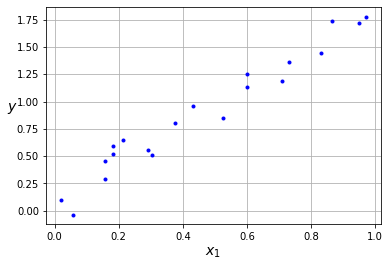

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

x = np.random.rand(20)
y = 2*x + (np.random.rand(20)-0.5)*0.5

plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

In [4]:
def gradient(w, x, y): 
    # calculamos la derivada de la funci√≥n de p√©rdida
    # con respecto a los par√°mteros `w`
    dldw = x*w - y
    dydw = x
    dldw = dldw*dydw
    return np.mean(2*dldw)

def cost(y, y_hat): 
    # calculamos la funci√≥n de p√©rdida
    return ((y_hat - y)**2).mean()

def solve(epochs = 29, w = 1.2, lr = 0.2):
    # iteramos un n√∫mero determinado de `epochs`
    # por cada epoch, calculamos gradientes y 
    # actualizamos los pesos
    weights = [(w, gradient(w, x, y), cost(x*w, y))]
    for i in range(1,epochs+1):
        dw = gradient(w, x, y)
        w = w - lr*dw
        weights.append((w, dw, cost(x*w, y)))
    return weights

In [8]:
from matplotlib import animation, rc
rc('animation', html='html5')

def init_fig(x, t, ws, cost_ws):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax2.plot(x, t, 'bo', label='y')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 2])
    ax2.set_xlabel('$x$', fontsize=15)
    ax2.set_ylabel('$y$', fontsize=15)
    ax2.yaxis.set_label_position('right')
    ax2.set_title('datos & modelo', fontsize=18)
    line2, = ax2.plot([], [], 'k-', label='$\hat{y}=x*w$')
    ax2.legend(loc=2)
    ax1.plot(ws, cost_ws, 'r-', label='MSE')
    ax1.set_ylim([0, 0.25])
    ax1.set_xlim([1, 2.75])
    ax1.set_xlabel('$w$', fontsize=15)
    ax1.set_ylabel('$MSE = 1 / N \sum (\hat{y}-y)^2$', fontsize=15)
    cost_text = ax1.set_title('$MSE_{}$'.format(0), fontsize=18)
    line1, = ax1.plot([], [], 'k:', label='derivada en $w$')
    pc_dots, = ax1.plot([], [], 'ko')
    ax1.legend(loc=2)
    ax1.grid(True)
    ax2.grid(True)
    return fig, ax1, ax2, line1, line2, pc_dots, cost_text

def get_anim(fig, ax1, ax2, line1, line2, pc_dots, cost_text, weights):
    xs = np.linspace(0, 4, num=100) 
    def anim(i):
        if i == 0:
            return [line1, line2, pc_dots, cost_text]
        (w, dw, cost) = weights[i-1]
        cost_text.set_text('$MSE_{{{}}} = {:.3f}$'.format(i, cost))
        ws, _, cs = zip(*weights[0:i])
        pc_dots.set_xdata(ws)
        pc_dots.set_ydata(cs)
        abline_values = [dw * (x-w) + cost for x in xs]
        line1.set_xdata(xs)
        line1.set_ydata(abline_values)
        # Plot fit
        # plot the fitted line
        line2.set_xdata([0, 1])
        line2.set_ydata([0*w, 1*w])
        ax2.legend(loc=2)
        return [line1, line2, pc_dots, cost_text]
    return anim

ws = np.linspace(0, 4, num=100)  
cost_ws = np.vectorize(lambda w: cost(x*w, y))(ws)  
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)

def compute_anim(weights):
    animate = get_anim(fig, ax1, ax2, line1, line2, pc_dots, cost_text, weights)
    anim = animation.FuncAnimation(fig, animate, frames=len(weights)+1, interval=200, blit=True)
    plt.close()
    return anim

weights = solve(w = 1.2)
anim = compute_anim(weights)
anim

En el primer ejemplo utilizamos el mismo valor inicial que vimos en el post anterior. En cada iteraci√≥n calculamos la derivada de la funci√≥n de p√©rdida con respecto al peso del modelo, la cual nos indicar√° la direcci√≥n en la que tenemos que actualizar su valor para reducir el error. Repetimos el proceso por un n√∫mero determinado de iteraciones (*epochs*).

In [5]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(w = 1.6)
anim = compute_anim(weights)
anim

En el siguiente ejemplo vemos el efecto que tiene utilizar un valor de inicializaci√≥n m√°s cercano al valor √≥ptimo. C√≥mo podemos ver, en este caso llegamos al valor √≥ptimo m√°s r√°pido, en menos *epochs*. Es com√∫n inicializar estos pesos de manera aleatoria (quiz√°s siguiendo una distribuci√≥n de probabilidad determinada). As√≠ pues, si tenemos suerte y los valores iniciales est√°n cercanos al √≥ptimo el proceso de optimizaci√≥n necesitar√° menos iteraciones y por lo tanto ser√° m√°s r√°pido (o para el mismo n√∫mero de iteraciones tendremos un mejor resultado).

In [6]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(w = 5)
anim = compute_anim(weights)
anim

En el √∫ltimo ejemplo utilizamos un valor m√°s alejado del √≥ptimo, c√≥mo podr√≠amos esperar necesitamos m√°s iteraciones para acercarnos al valor √≥ptimo. 

C√≥mo hemos podido ver la inicializaci√≥n de nuestro modelo tendr√° un efecto en el proceso de optimizaci√≥n, principalmente en el n√∫mero de iteraciones que necesitaremos para llegar al valor √≥ptimo. Sin embargo, debido a que el algoritmo de descenso por gradiente no nos garantiza encontrar el valor √≥ptimo global y puede quedarse "atascado" en un valor √≥ptimo local, es com√∫n realizar m√∫ltiples optimizaciones con diferentes valores iniciales.

![](https://www.monografias.com/trabajos95/redes-neuronales-artificiales-metodologia-desarrollo-y-aplicaciones/image010.jpg)

### Efectos del *learning rate*

En esta secci√≥n vemos c√≥mo afecta el valor escogido del *learning rate* al proceso de optimizaci√≥n. Para ello usarmos el mismo valor inicial en todos los casos.

In [7]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(lr = 0.2)
anim = compute_anim(weights)
anim

En el primer caso utilizamos un valor de $\eta = 0.2$ y podemos ver como llegamos a la soluci√≥n √≥ptima poco a poco.

In [8]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(lr = 0.01)
anim = compute_anim(weights)
anim

Un valor muy peque√±o nos sigue llevando a la soluci√≥n √≥ptima, pero requiriendo de muchas iteraciones.

In [9]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(lr = 1)
anim = compute_anim(weights)
anim

En el caso anterior utilizamos un valor m√°s grande de $\eta = 1$ y observamos como llegamos a la soluci√≥n √≥ptima mucho m√°s r√°pido, en apenas 5 iteraciones mientras que en el caso anterior necesit√°bamos 30. Recordemos que los pesos los actualizamos siguiendo la ecuaci√≥n $w \leftarrow w - \eta \frac{\partial MSE}{\partial w}$ por lo que el *learning rate* determinar√° como de grande ser√° el paso que daremos en cada iteraci√≥n en direcci√≥n al valor √≥ptimo.

In [10]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(lr = 3)
anim = compute_anim(weights)
anim

Sin embargo, si utilizamos un valor demasiado grande podemos observar que en vez de acelerar el proceso de optimizaci√≥n se realentiza, necesitando m√°s iteraciones para llegar al valor √≥ptimo. A√∫n as√≠, vemos que el proceso converge.

In [11]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(w = 1.8, lr = 3.5)
anim = compute_anim(weights)
anim

Cuando utilizamos un valor demasiado grande, el proceso de optimizaci√≥n no puede converger ya que los pasos que damos son muy grandes consiguiendo justo el efecto contrario: en vez de dar pasos hacia el valor √≥ptimo nos alejamos de √©l. Incluso si nuestra inicializaci√≥n es buena, un *learning rate* grande ser√° perjudicial.

Hemos visto el efecto que tiene el *learning rate* en el entrenamiento de nuesto `Perceptr√≥n`. Un valor muy peque√±o resulta en un proceso de optimizaci√≥n lento, mientras que un valor muy grande har√° que el proceso sea divergente. As√≠ pues tendremos que utilizar valores adecuados para tener una optimizaci√≥n r√°pida y convergente. Lamentablemente un valor "muy peque√±o" o "muy grande" o "adecuado" va a depender de la funci√≥n de p√©rdida y modelo utilizados, por lo que cada caso requerir√° de varias pruebas para encontrar el mejor valor de *learning rate*. 

![](https://miro.medium.com/max/918/0*uIa_Dz3czXO5iWyI.)

### Variantes del Descenso por Gradiente

En todos los casos anteriores hemos utilizado todos los elementos del dataset en el c√°lculo del gradiente. Esto se conoce como `Batch Gradient Descent` y su principal limitaci√≥n es aquellos casos en los que el conjunto de datos es tan grande que no cabe en la memoria del ordenador. En estos casos tenemos dos alternativas. En el caso diametralmente opuesto, `Stochastic Gradient Descent` calcula la derivada por cada elemento del dataset de manera independiente. A√∫n as√≠, la opci√≥n m√°s utilizada es `Mini-Batch Gradient Descent`, m√©todo en el que usaremos un peque√±o conjunto de los datos para calcular la derivada de la funci√≥n de p√©rdida en cada iteraci√≥n.

#### Stochastic Gradient Descent

In [7]:
def solve_sgd(epochs = 5, w = 1.2, lr = 0.2):
    # stochastic gradient descent
    weights = [(w, gradient(w, x, y), cost(x*w, y))]
    for i in range(1,epochs+1):
        # un update por cada elemento del dataset
        for _x, _y in zip(x, y):
            dw = gradient(w, _x, _y)
            w = w - lr*dw
            weights.append((w, dw, cost(_x*w, _y)))
    return weights

In [9]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve_sgd()
anim = compute_anim(weights)
anim

Este algoritmo es capaz de converger, pero en esta variante el proceso de optimizaci√≥n es err√°tico, ya que la estimaci√≥n del gradiente var√≠a mucho de un punto a otro.

#### Mini-Batch Gradient Descent

In [13]:
def solve_mbgd(epochs = 20, w = 1.2, lr = 0.2, batch_size=10):
    # mini-batch gradient descent
    batches = len(x) // batch_size
    weights = [(w, gradient(w, x, y), cost(x*w, y))]
    for i in range(1,epochs+1):
        # un update por cada `batch`
        for j in range(batches):
            _x = x[j*batch_size:(j+1)*batch_size]
            _y = y[j*batch_size:(j+1)*batch_size]
            dw = gradient(w, _x, _y)
            w = w - lr*dw 
            # Guardar grupo de baches por iteracion
            weights.append((w, dw, cost(_x*w, _y)))
    return weights

In [14]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve_mbgd()
anim = compute_anim(weights)
anim

En este caso observamos un comportamiento intermedio entre utilizar todos los datos para hacer un paso de optimizaci√≥n o un solo elemento del dataset. El proceso sigue convergiendo, no de manera tan suave como en la variante `Batch Gradient Descent`, sigue siendo un poco err√°tico, pero no tanto como la variante `Stochastic Gradient Descent`. Este hecho hace que sea la opci√≥n por defecto en la mayor√≠a de procesos de optimizaci√≥n. 

> ‚ö° Una implementaci√≥n en modo *mini batch* siempre nos permitir√° utilizar la variante *batch* o *stochastic* simplemente usando un *batch size* igual al n√∫mero de elementos del dataset para el primer caso o igual a 1 para el segundo.

![](https://suniljangirblog.files.wordpress.com/2018/12/descent.png?w=908)